# Introduction

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from qctrlvisualizer import get_qctrl_style, plot_controls
from qctrl import Qctrl

In [2]:
#qctrl = Qctrl(email='diogo.abc.cruz@gmail.com', password='Y8DhQ4NAFWYnh9s')
qctrl = Qctrl()

# Simulating an ideal superconducting qubit

In [3]:
def simulate_ideal_qubit(
    duration=1, values=np.array([np.pi]), shots=1024, repetitions=1
):

    b = np.array([[0, 1], [0, 0]])  # Lowering operator
    initial_state = np.array([[1], [0]])  # Initial state of qubit in |0>

    with qctrl.create_graph() as graph:

        # Create time dependent \Omega(t)
        drive = qctrl.operations.pwc_signal(duration=duration, values=values)

        # Construct Hamiltonian (\Omega(t) b + \Omega^*(t) b^\dagger)/2
        hamiltonian = qctrl.operations.pwc_operator_hermitian_part(
            qctrl.operations.pwc_operator(signal=drive, operator=b)
        )

        # Solve Schrodinger's equation and get total unitary at the end
        unitary = qctrl.operations.time_evolution_operators_pwc(
            hamiltonian=hamiltonian,
            sample_times=np.array([duration]),
        )[-1]
        unitary.name = "unitary"

        # Repeat final unitary
        repeated_unitary = np.eye(2)
        for _ in range(repetitions):
            repeated_unitary = repeated_unitary @ unitary
        repeated_unitary.name = "repeated_unitary"

        # Calculate final state.
        state = repeated_unitary @ initial_state

        # Calculate final populations.
        populations = qctrl.operations.abs(state[:, 0]) ** 2
        # Normalize populations because of numerical precision
        norm = qctrl.operations.sum(populations)
        populations = populations / norm
        populations.name = "populations"

    # Evaluate graph.
    result = qctrl.functions.calculate_graph(
        graph=graph,
        output_node_names=["unitary", "repeated_unitary", "populations"],
    )

    # Extract outputs.
    unitary = result.output["unitary"]["value"]
    repeated_unitary = result.output["repeated_unitary"]["value"]
    populations = result.output["populations"]["value"]

    # Sample projective measurements.
    measurements = np.random.choice(2, size=shots, p=populations)

    results = {"unitary": unitary, "measurements": measurements}

    return results

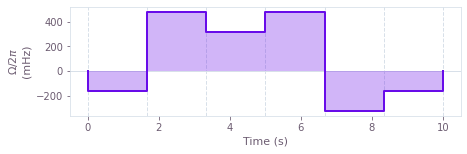

In [4]:
duration = 10
values = np.array([-1, 3, 2, 3, -2, -1])


def get_pulse_plot_dict(name="default", duration=1, values=np.array([1.0])):
    segments = len(values)
    segment_durations = duration / segments
    pulse_plot_dict = {
        name: [{"duration": segment_durations, "value": v} for v in values]
    }
    return pulse_plot_dict


example_pulse = get_pulse_plot_dict(name="$\Omega$", duration=duration, values=values)

fig = plt.figure()
plot_controls(fig, example_pulse, polar=False)
plt.show()

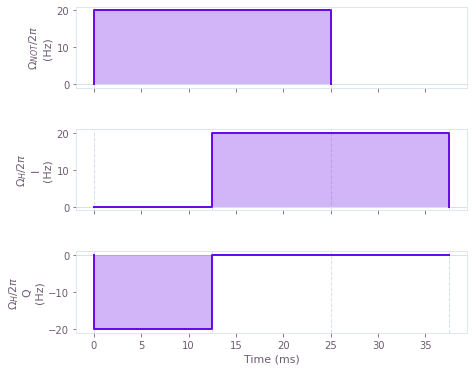

In [5]:
max_rabi_rate = 20 * 2 * np.pi  # MHz
not_duration = np.pi / (max_rabi_rate)  # us
not_values = np.array([max_rabi_rate])
h_duration = 3 * np.pi / (2 * max_rabi_rate)  # us
h_values = np.array([-1j * max_rabi_rate, max_rabi_rate, max_rabi_rate])

not_pulse = get_pulse_plot_dict(
    name="$\Omega_{NOT}$", duration=not_duration, values=not_values
)
h_pulse = get_pulse_plot_dict(name="$\Omega_{H}$", duration=h_duration, values=h_values)
both_pulses = {**not_pulse, **h_pulse}

fig = plt.figure()
plot_controls(fig, both_pulses, polar=False)
plt.show()


In [6]:
shots = 1024

In [7]:
not_results = simulate_ideal_qubit(
    duration=not_duration, values=not_values, shots=shots
)
h_results = simulate_ideal_qubit(duration=h_duration, values=h_values, shots=shots)

  0%|          | 0/100 [00:00<?, ?it/s]

Your task calculate_graph has completed in 3s.


  0%|          | 0/100 [00:00<?, ?it/s]

Your task calculate_graph has completed in 3s.


In [8]:
error_norm = (
    lambda operate_a, operator_b: 1
    - np.abs(np.trace((operate_a.conj().T @ operator_b)) / 2) ** 2
)

realised_not_gate = not_results["unitary"]
ideal_not_gate = np.array([[0, 1], [1, 0]])
not_error = error_norm(realised_not_gate, ideal_not_gate)
realised_h_gate = h_results["unitary"]
ideal_h_gate = (1 / np.sqrt(2)) * np.array([[1, 1], [1, -1]])
h_error = error_norm(realised_h_gate, ideal_h_gate)

print("Realised NOT Gate:")
print(realised_not_gate)
print("Ideal NOT Gate:")
print(ideal_not_gate)
print("NOT Gate Error:" + str(not_error) + "\n")
print("Realised H Gate:")
print(realised_h_gate)
print("Ideal H Gate:")
print(ideal_h_gate)
print("H Gate Error:" + str(h_error))

Realised NOT Gate:
[[2.83276945e-16+0.j 0.00000000e+00-1.j]
 [0.00000000e+00-1.j 2.83276945e-16+0.j]]
Ideal NOT Gate:
[[0 1]
 [1 0]]
NOT Gate Error:4.440892098500626e-16

Realised H Gate:
[[ 2.22044605e-16-0.70710678j -2.22044605e-16-0.70710678j]
 [ 2.22044605e-16-0.70710678j  2.22044605e-16+0.70710678j]]
Ideal H Gate:
[[ 0.70710678  0.70710678]
 [ 0.70710678 -0.70710678]]
H Gate Error:1.1102230246251565e-15


In [9]:
not_measurements = not_results["measurements"]
h_measurements = h_results["measurements"]


def estimate_probability_of_one(measurements):
    size = len(measurements)
    probability = np.mean(measurements)
    standard_error = np.std(measurements) / np.sqrt(size)
    return (probability, standard_error)


not_probability, not_standard_error = estimate_probability_of_one(not_measurements)
h_probability, h_standard_error = estimate_probability_of_one(h_measurements)


In [10]:
print("NOT estimated probability of getting 1:" + str(not_probability))
print("NOT estimate standard error:" + str(not_standard_error))
print("H estimated probability of getting 1:" + str(h_probability))
print("H estimate standard error:" + str(h_standard_error))

NOT estimated probability of getting 1:1.0
NOT estimate standard error:0.0
H estimated probability of getting 1:0.513671875
H estimate standard error:0.015619157652555254


In [11]:
epsilon = 0.003
h_duration = (np.pi + epsilon) / (2 * max_rabi_rate)  # us

repetitions = np.array([1, 17, 127])
repetition_results = []

In [12]:
for reps in repetitions:
    repetition_results.append(
        simulate_ideal_qubit(
            duration=h_duration, values=values, shots=shots, repetitions=reps
        )
    )

  0%|          | 0/100 [00:00<?, ?it/s]

Your task calculate_graph has completed in 3s.


  0%|          | 0/100 [00:00<?, ?it/s]

Your task calculate_graph has completed in 3s.


  0%|          | 0/100 [00:00<?, ?it/s]

Your task calculate_graph has completed in 3s.


In [13]:
probability_estimates = np.zeros(3)
standard_errors = np.zeros(3)

for count, result in enumerate(repetition_results):
    probability_estimates[count], standard_errors[count] = estimate_probability_of_one(
        result["measurements"]
    )

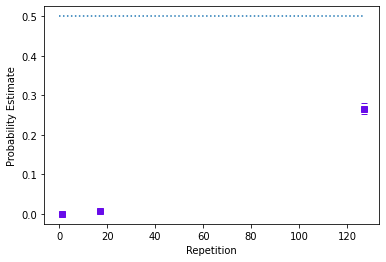

In [14]:
plt.plot(repetitions, probability_estimates, "s", color="#680CE9")
plt.plot(repetitions, probability_estimates + standard_errors, "_", color="#680CE9")
plt.plot(repetitions, probability_estimates - standard_errors, "_", color="#680CE9")
plt.hlines(0.5, 0, 127, linestyle=":")
plt.xlabel("Repetition")
plt.ylabel("Probability Estimate")
plt.show()

# Simulating a more realistic superconducting qubit

In [15]:
def simulate_more_realistic_qubit(
    duration=1, values=np.array([np.pi]), shots=1024, repetitions=1
):

    # 1. Limits for drive amplitudes
    assert np.amax(values) <= 1.0
    assert np.amin(values) >= -1.0
    max_drive_amplitude = 2 * np.pi * 20  # MHz

    # 2. Dephasing error
    dephasing_error = -2 * 2 * np.pi  # MHz

    # 3. Amplitude error
    amplitude_i_error = 0.98
    amplitude_q_error = 1.03

    # 4. Control line bandwidth limit
    cut_off_frequency = 2 * np.pi * 10  # MHz
    resample_segment_count = 1000

    # 5. SPAM error confusion matrix
    confusion_matrix = np.array([[0.99, 0.01], [0.02, 0.98]])

    # Lowering operator
    b = np.array([[0, 1], [0, 0]])
    # Number operator
    n = np.diag([0, 1])
    # Initial state
    initial_state = np.array([[1], [0]])

    with qctrl.create_graph() as graph:
        # Apply 1. max Rabi rate.
        values = values * max_drive_amplitude

        # Apply 3. amplitude errors.
        values_i = np.real(values) * amplitude_i_error
        values_q = np.imag(values) * amplitude_q_error
        values = values_i + 1j * values_q

        # Apply 4. bandwidth limits
        drive_unfiltered = qctrl.operations.pwc_signal(duration=duration, values=values)
        drive_filtered = qctrl.operations.convolve_pwc(
            pwc=drive_unfiltered,
            kernel_integral=qctrl.operations.sinc_integral_function(cut_off_frequency),
        )
        drive = qctrl.operations.discretize_stf(
            drive_filtered, duration=duration, segments_count=resample_segment_count
        )

        # Construct microwave drive
        drive_term = qctrl.operations.pwc_operator_hermitian_part(
            qctrl.operations.pwc_operator(signal=drive, operator=b)
        )

        # Construct 2. dephasing term.
        dephasing_term = qctrl.operations.constant_pwc_operator(
            operator=dephasing_error * n,
            duration=duration,
        )

        # Construct Hamiltonian.
        hamiltonian = qctrl.operations.pwc_sum(
            [
                drive_term,
                dephasing_term,
            ]
        )

        # Solve Schrodinger's equation and get total unitary at the end
        unitary = qctrl.operations.time_evolution_operators_pwc(
            hamiltonian=hamiltonian,
            sample_times=np.array([duration]),
        )[-1]
        unitary.name = "unitary"

        # Repeat final unitary
        repeated_unitary = np.eye(2)
        for _ in range(repetitions):
            repeated_unitary = repeated_unitary @ unitary
        repeated_unitary.name = "repeated_unitary"

        # Calculate final state.
        state = repeated_unitary @ initial_state

        # Calculate final populations.
        populations = qctrl.operations.abs(state[:, 0]) ** 2
        # Normalize populations
        norm = qctrl.operations.sum(populations)
        populations = populations / norm
        populations.name = "populations"

    # Evaluate graph.
    result = qctrl.functions.calculate_graph(
        graph=graph,
        output_node_names=["unitary", "repeated_unitary", "populations"],
    )

    # Extract outputs.
    unitary = result.output["unitary"]["value"]
    repeated_unitary = result.output["repeated_unitary"]["value"]
    populations = result.output["populations"]["value"]

    # Sample projective measurements.
    true_measurements = np.random.choice(2, size=shots, p=populations)
    measurements = np.array(
        [np.random.choice(2, p=confusion_matrix[m]) for m in true_measurements]
    )

    results = {"unitary": unitary, "measurements": measurements}

    return results

In [16]:
max_rabi_rate = 20 * 2 * np.pi  # MHz
not_duration = np.pi / (max_rabi_rate)  # us
h_duration = np.pi / (2 * max_rabi_rate)  # us
shots = 1024

values = np.array([1.0])

In [17]:
not_results = simulate_more_realistic_qubit(
    duration=not_duration, values=values, shots=shots
)
h_results = simulate_more_realistic_qubit(
    duration=h_duration, values=values, shots=shots
)

  0%|          | 0/100 [00:00<?, ?it/s]

Your task calculate_graph has completed in 3s.


  0%|          | 0/100 [00:00<?, ?it/s]

Your task calculate_graph has completed in 3s.


In [18]:
realised_not_gate = not_results["unitary"]
ideal_not_gate = np.array([[0, -1j], [-1j, 0]])
not_error = error_norm(realised_not_gate, ideal_not_gate)
realised_h_gate = h_results["unitary"]
ideal_h_gate = (1 / np.sqrt(2)) * np.array([[1, -1j], [-1j, 1]])
h_error = error_norm(realised_h_gate, ideal_h_gate)

not_measurements = not_results["measurements"]
h_measurements = h_results["measurements"]
not_probability, not_standard_error = estimate_probability_of_one(not_measurements)
h_probability, h_standard_error = estimate_probability_of_one(h_measurements)

print("Realised NOT Gate:")
print(realised_not_gate)
print("Ideal NOT Gate:")
print(ideal_not_gate)
print("NOT Gate Error:" + str(not_error))
print("NOT estimated probability of getting 1:" + str(not_probability))
print("NOT estimate standard error:" + str(not_standard_error) + "\n")

print("Realised H Gate:")
print(realised_h_gate)
print("Ideal H Gate:")
print(ideal_h_gate)
print("H Gate Error:" + str(h_error))
print("H estimated probability of getting 1:" + str(h_probability))
print("H estimate standard error:" + str(h_standard_error))

Realised NOT Gate:
[[0.75412104-0.02524955j 0.1026601 -0.64817036j]
 [0.1026601 -0.64817036j 0.70940919+0.25704996j]]
Ideal NOT Gate:
[[ 0.+0.j -0.-1.j]
 [-0.-1.j  0.+0.j]]
NOT Gate Error:0.5693360860922008
NOT estimated probability of getting 1:0.42578125
NOT estimate standard error:0.015451902983419906

Realised H Gate:
[[0.98219782-0.00092913j 0.01473832-0.18726817j]
 [0.01473832-0.18726817j 0.96995998+0.15456728j]]
Ideal H Gate:
[[0.70710678+0.j         0.        -0.70710678j]
 [0.        -0.70710678j 0.70710678+0.j        ]]
H Gate Error:0.31912041750757547
H estimated probability of getting 1:0.044921875
H estimate standard error:0.006472892706263649


# The more realistic qubit vs the qubit in the cloud

In [19]:

control_count = 5
segment_count = 16
duration = 30.0
shot_count = 32

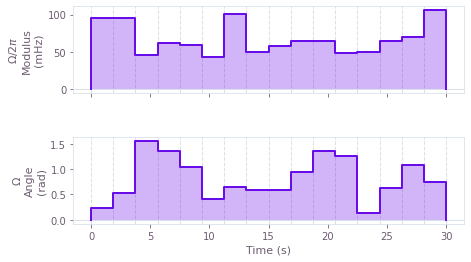

In [20]:
controls = []
for k in range(control_count):
    # Create a random string of complex numbers for each controls.
    real_part = np.random.random(size=[segment_count])
    imag_part = np.random.random(size=[segment_count])
    values = 0.15 * k * (real_part + 1j * imag_part)

    controls.append({"duration": duration, "values": values})

# Plot the last control as an example.
plot_controls(
    figure=plt.figure(),
    controls={
        "$\Omega$": [
            {"duration": duration / segment_count, "value": value} for value in values
        ]
    },
)

In [21]:
# Obtain the results of the experiment.
experiment_results = qctrl.functions.calculate_qchack_measurements(
    controls=controls,
    shot_count=shot_count,
)

  0%|          | 0/100 [00:00<?, ?it/s]

Your task calculate_qchack_measurements has completed in 3s.


In [22]:
measurements = experiment_results.measurements
for k, measurement_counts in enumerate(measurements):
    print(f"control #{k}: {measurement_counts}")

control #0: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
control #1: [0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1]
control #2: [1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1]
control #3: [0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1]
control #4: [0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1]


In [23]:
for k, measurement_counts in enumerate(measurements):
    p0 = measurement_counts.count(0) / shot_count
    p1 = measurement_counts.count(1) / shot_count
    p2 = measurement_counts.count(2) / shot_count
    print(f"control #{k}: P(|0>) = {p0:.2f}, P(|1>) = {p1:.2f}, P(|2>) = {p2:.2f}")

control #0: P(|0>) = 1.00, P(|1>) = 0.00, P(|2>) = 0.00
control #1: P(|0>) = 0.78, P(|1>) = 0.22, P(|2>) = 0.00
control #2: P(|0>) = 0.47, P(|1>) = 0.53, P(|2>) = 0.00
control #3: P(|0>) = 0.44, P(|1>) = 0.56, P(|2>) = 0.00
control #4: P(|0>) = 0.47, P(|1>) = 0.53, P(|2>) = 0.00


In [24]:
repetitions = [1, 4, 16, 32, 64]

controls = []
# Create a random string of complex numbers for all control,
# but set a different repetition_count for each control.
real_part = np.random.random(size=[segment_count])
imag_part = np.random.random(size=[segment_count])
values = 0.5 * (real_part + 1j * imag_part)

for repetition_count in repetitions:
    controls.append(
        {"duration": duration, "values": values, "repetition_count": repetition_count}
    )

experiment_results = qctrl.functions.calculate_qchack_measurements(
    controls=controls,
    shot_count=shot_count,
)

for repetition_count, measurement_counts in zip(
    repetitions, experiment_results.measurements
):
    p0 = measurement_counts.count(0) / shot_count
    p1 = measurement_counts.count(1) / shot_count
    p2 = measurement_counts.count(2) / shot_count
    print(
        f"With {repetition_count:2d} repetitions: P(|0>) = {p0:.2f}, P(|1>) = {p1:.2f}, P(|2>) = {p2:.2f}"
    )


  0%|          | 0/100 [00:00<?, ?it/s]

Your task calculate_qchack_measurements has completed in 3s.
With  1 repetitions: P(|0>) = 0.38, P(|1>) = 0.62, P(|2>) = 0.00
With  4 repetitions: P(|0>) = 0.28, P(|1>) = 0.72, P(|2>) = 0.00
With 16 repetitions: P(|0>) = 0.19, P(|1>) = 0.81, P(|2>) = 0.00
With 32 repetitions: P(|0>) = 0.97, P(|1>) = 0.03, P(|2>) = 0.00
With 64 repetitions: P(|0>) = 1.00, P(|1>) = 0.00, P(|2>) = 0.00
